In [32]:
# Import Libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Bioinformatics Libraries
import scanpy as sc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Scapy Settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.2 scipy==1.11.4 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [33]:
# Load the pbmc3k dataset
sc.datasets.pbmc3k()
adata = sc.read_10x_mtx(
    # the directory with the `.mtx` file
    'data/filtered_gene_bc_matrices/hg19/',
    # use gene symbols for the variable names (variables-axis index)
    var_names='gene_symbols',
    # write a cache file for faster subsequent reading
    cache=True,
)

adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'
adata.write('../write/pbmc3k_raw.h5ad', compression='gzip')
print(adata)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad
AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


normalizing counts per cell
    finished (0:00:00)


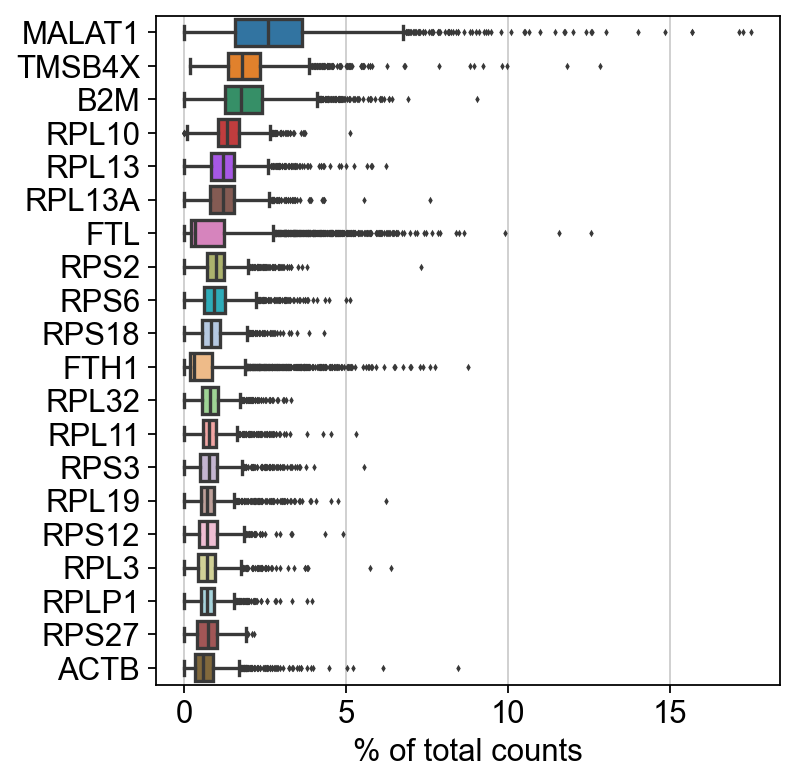

In [34]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )

In [35]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)


filtered out 19024 genes that are detected in less than 3 cells


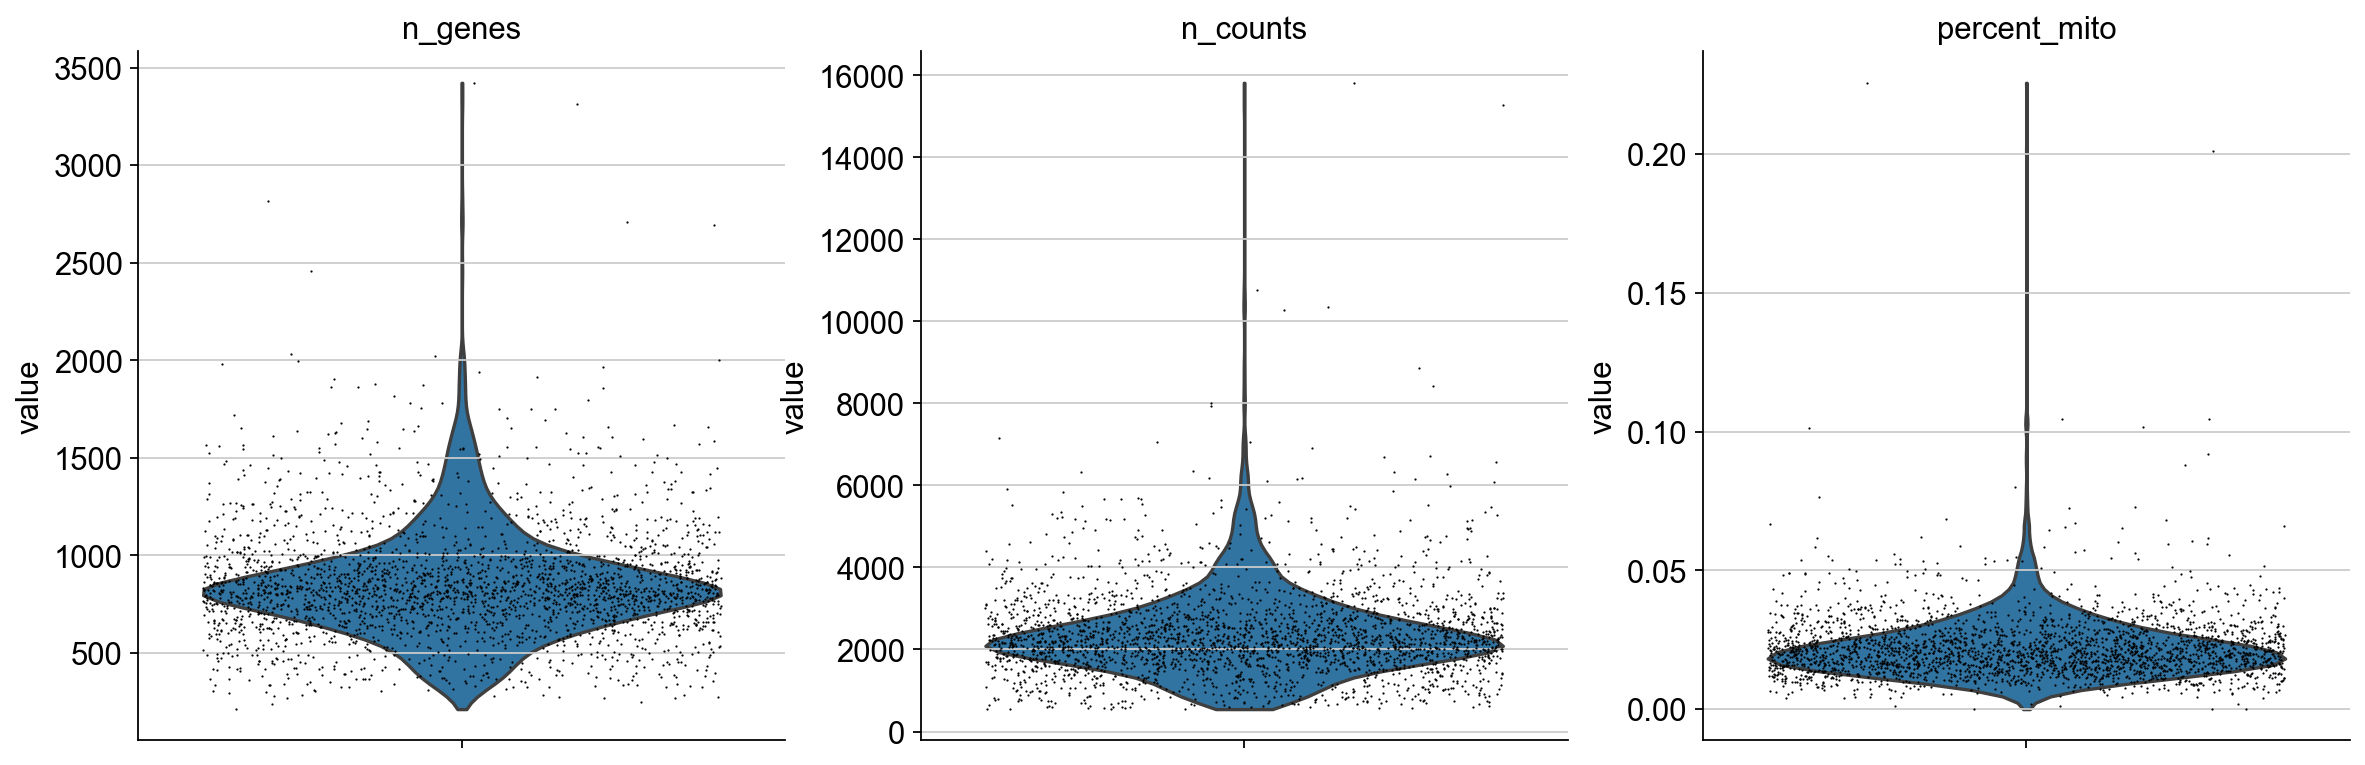

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'


In [36]:
# quality control
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                jitter=0.4, multi_panel=True)

adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print(adata)


In [37]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)


normalizing counts per cell


    finished (0:00:00)


In [38]:
# Store the raw data
adata.raw = adata


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


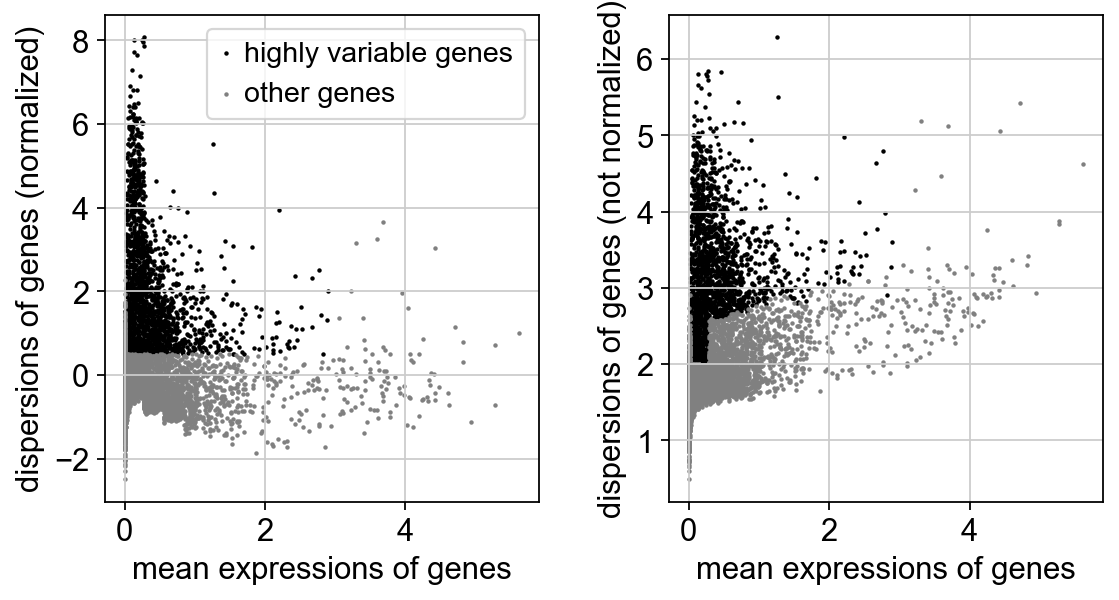

1838


In [39]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# Filter the data
adata = adata[:, adata.var.highly_variable]

# Summarize the highly variable genes
print(adata.var.highly_variable.sum())


In [40]:
# # Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed.
# sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

In [41]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## Dimension Reduction

### scry

In [42]:
# # If scry is not installed in R, you can install it using the following R commands:
# # Initialize R instance
# import rpy2.robjects as robjects
# r = robjects.r

# # Install BiocManager directly using R
# r('install.packages("BiocManager", repos="http://cran.us.r-project.org")')
# r('BiocManager::install()')

# # Now, try installing scry package
# r('BiocManager::install("scry")')


In [43]:
# Import R packages
import rpy2.robjects.packages as rpackages
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.vectors import DataFrame


In [44]:
# Activate the pandas2ri interface
pandas2ri.activate()

# Convert the AnnData to a DataFrame for the count data
with localconverter(robjects.default_converter + pandas2ri.converter):
    df = adata.to_df()

df.shape

(2638, 1838)

In [45]:
df_transposed = df.T

In [46]:
# Convert the Pandas DataFrame to an R data frame
with localconverter(robjects.default_converter + pandas2ri.converter):
    count_data_r = robjects.conversion.py2rpy(df_transposed)

robjects.r.assign('count_data_r', count_data_r)


AAACATACAACCAC-1,AAACATTGAGCTAC-1,AAACATTGATCAGC-1,...,TTTCTACTTCCTCG-1,TTTGCATGAGAGGC-1,TTTGCATGCCTCAC-1
...,...,...,...,...,...,...


In [47]:
nrows = robjects.r['nrow'](count_data_r)[0]
ncols = robjects.r['ncol'](count_data_r)[0]
print(f"Shape of DataFrame: ({nrows}, {ncols})")

Shape of DataFrame: (1838, 2638)


In [48]:
# Load the SIMLR library in R
robjects.r('library(scry)')

# Calculate the distance matrix in R
robjects.r('''
    distance_matrix_r <- as.matrix(dist(t(count_data_r)))
''')


In [49]:
# Run MDS using cmdscale on the distance matrix and get the full embedding
robjects.r('mds_result_full <- cmdscale(distance_matrix_r, k=10)')  # Extract the full embedding matrix
mds_result = robjects.r('mds_result_full')




In [56]:
type(mds_result)

numpy.ndarray

In [50]:
from rpy2.robjects.conversion import localconverter

# Convert the result to a Python object
with localconverter(robjects.default_converter + pandas2ri.converter):
    mds_embedding= robjects.conversion.rpy2py(mds_result)

# Check the shape and contents of the full embedding
print("Shape of full MDS embedding:", mds_embedding.shape)
print("First few rows of full MDS embedding:", mds_embedding[:5, :])

Shape of full MDS embedding: (2638, 10)
First few rows of full MDS embedding: [[-4.43402603e+00  2.50231580e-01  1.49886119e+00 -3.17138560e-03
  -9.15280489e-01  6.78499433e-01  1.08896184e+00  9.32777697e-01
   3.11469375e+00  1.12125983e+00]
 [-7.58417529e-01 -4.24860284e+00 -6.06687725e+00 -1.80440506e+00
  -1.21720736e+00  6.36904973e-01 -3.53633606e-01 -4.21227363e-01
   1.08883594e+00 -1.47666675e+00]
 [-2.82866270e+00  1.39535800e+00  2.97546803e+00 -3.69726225e+00
  -1.02233418e+00 -7.25170262e-01 -1.83982675e+00 -9.27836113e-01
  -1.17348856e+00 -1.19043772e+00]
 [ 1.12770435e+01  6.25911234e-01 -1.21109478e+00 -5.94052046e-01
  -9.59344807e-01 -6.73749679e-01  7.47516001e-01  3.73408474e-01
  -9.81769232e-01  3.15135206e-01]
 [-2.07916332e+00  7.29067653e+00 -4.43214587e+00  5.05811029e+00
   2.84362793e+00 -3.13794975e+00 -6.58448786e-01  7.25083516e-01
  -2.06408383e+00  1.73711198e+00]]


In [51]:
print(type(mds_embedding))
print(mds_embedding[:5])


<class 'numpy.ndarray'>
[[-4.43402603e+00  2.50231580e-01  1.49886119e+00 -3.17138560e-03
  -9.15280489e-01  6.78499433e-01  1.08896184e+00  9.32777697e-01
   3.11469375e+00  1.12125983e+00]
 [-7.58417529e-01 -4.24860284e+00 -6.06687725e+00 -1.80440506e+00
  -1.21720736e+00  6.36904973e-01 -3.53633606e-01 -4.21227363e-01
   1.08883594e+00 -1.47666675e+00]
 [-2.82866270e+00  1.39535800e+00  2.97546803e+00 -3.69726225e+00
  -1.02233418e+00 -7.25170262e-01 -1.83982675e+00 -9.27836113e-01
  -1.17348856e+00 -1.19043772e+00]
 [ 1.12770435e+01  6.25911234e-01 -1.21109478e+00 -5.94052046e-01
  -9.59344807e-01 -6.73749679e-01  7.47516001e-01  3.73408474e-01
  -9.81769232e-01  3.15135206e-01]
 [-2.07916332e+00  7.29067653e+00 -4.43214587e+00  5.05811029e+00
   2.84362793e+00 -3.13794975e+00 -6.58448786e-01  7.25083516e-01
  -2.06408383e+00  1.73711198e+00]]


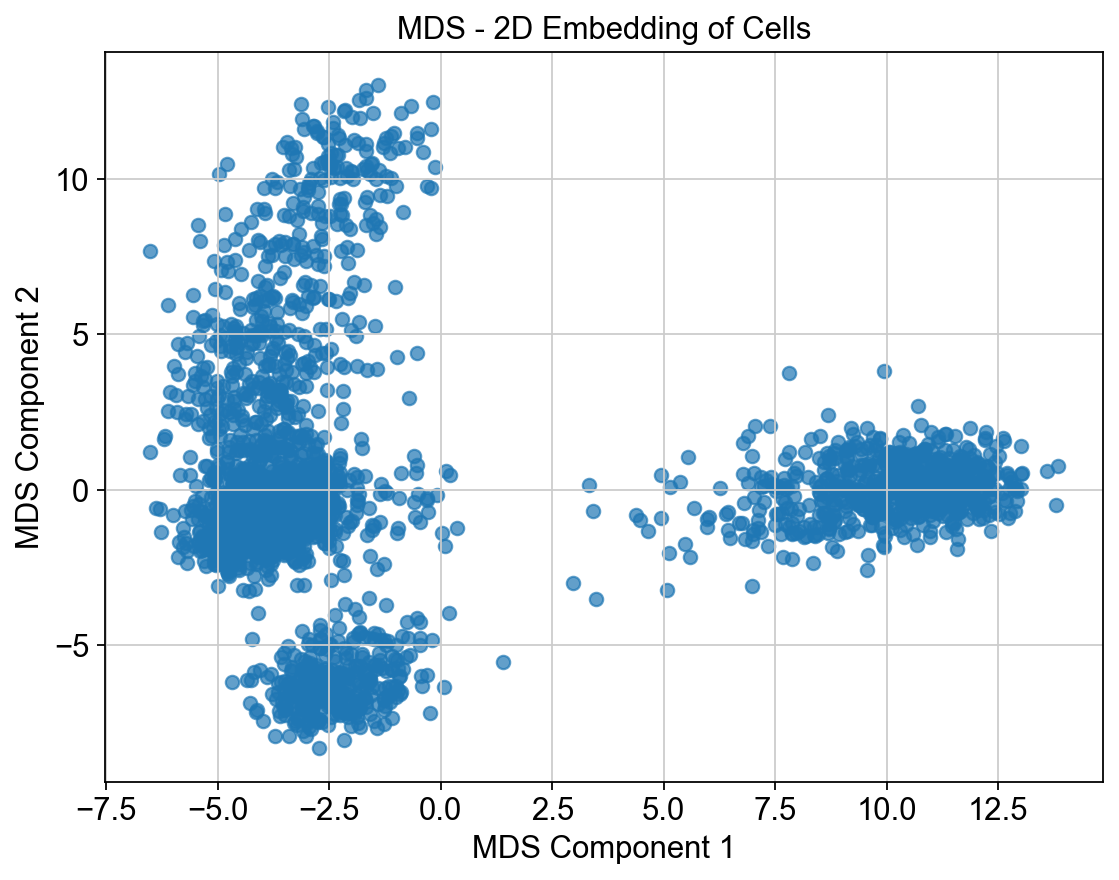

In [52]:
# Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(mds_embedding[:, 0], mds_embedding[:, 1], alpha=0.7)
plt.title('MDS - 2D Embedding of Cells')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.show()

In [53]:
# Add the MDS embedding to the AnnData object
adata.obsm['X_mds'] = mds_embedding

In [54]:
# Save the AnnData object
adata.write('../write/pbmc3k_scry.h5ad', compression='gzip')

In [55]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_mds'

In [57]:
# The result is in Z, which we can add back to the AnnData object
scry_df= adata.obsm['X_mds']

# Convert ZIFA results to DataFrame
scry_df = pd.DataFrame(scry_df, index=adata.obs_names, columns=[f'X_mds{i+1}' for i in range(10)])

# Save to CSV file
scry_df.to_csv('../csv_files/scry_results.csv')